# 1. Before Using this notebook:

## 1a. Install brainlit, and other packages that this notebook uses
## 1b. Write images to s3 using CloudReg
    - e.g. python -m cloudreg.scripts.create_precomputed_volumes --s3_input_paths /mnt/NAS/SmartSPIM_Data/2022_03_02/20220302_14_40_04_8529_destriped_DONE/Ex_561_Em_600_stitched --s3_output_paths  s3://smartspim-precomputed-volumes/2022_03_02/8529/Ch_561_v2  --voxel_size 1.83 1.83 2 --num_procs 24 --resample_iso False
## 1c. Make point annotations in neuroglancer to identify subvolumes for validation (and possible training)
    - instructions: https://neurodata.io/help/neuroglancer-pt-annotations/
## 1d. Update axon_data.py file

## \*Inputs\*

In [1]:
antibody_layer = "Ch_647"
background_layer = "Ch_561"
endogenous_layer = "Ch_488"

In [2]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
from skimage import io, measure
import napari
import random
import h5py
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
from skimage.morphology import skeletonize
from axon_data import brain2paths, brain2centers
import os
from util import json_to_points, find_atlas_level_label, fold
import scipy.ndimage as ndi
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

%gui qt5

In [3]:
for id in brain2paths.keys():
    if "base" in brain2paths[id].keys() and "val_info" in brain2paths[id].keys():
        base = brain2paths[id]["base"]
        if "http" in base:
            print(f"Sample {id}: http in basepath, which may cause write errors")
        for layer in [antibody_layer, background_layer, endogenous_layer]:
            try:
                CloudVolume(base + layer)
            except:
                print(f"Sample {id}: Layer {layer} not found in {base}")

        try:
            url = brain2paths[id]["val_info"]["url"]
            layer = brain2paths[id]["val_info"]["layer"]
            pts = json_to_points(url)[layer]
        except:
            print(f"Sample {id}: Error with val_info")

        if "train_info" in brain2paths[id].keys():
            try:
                url = brain2paths[id]["train_info"]["url"]
                layer = brain2paths[id]["train_info"]["layer"]
                pts = json_to_points(url)[layer]
            except:
                print(f"Sample {id}: Error with train_info")
    else:
        print(f"Sample {id}: Does not conform to desired format")

Sample 2: Does not conform to desired format
Sample 1: Does not conform to desired format
Sample 3: Does not conform to desired format
Sample 4: Does not conform to desired format
Sample 8613: Does not conform to desired format
Sample 8604: Does not conform to desired format
Sample 8590_v2: Does not conform to desired format
Sample 8612: Does not conform to desired format
Sample 8788: Does not conform to desired format
Sample 11537: Does not conform to desired format


# 2. Download benchmark data

## \*Inputs\*

In [ ]:
brain = "8589"  # brain ID
axon_data_dir = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/"  # path to directory where training/validation data should be stored
dataset_to_save = "val"  # train or val

In [ ]:
# Useful variables
base_dir = axon_data_dir + "brain" + brain + "/"

if brain not in brain2paths.keys():
    raise ValueError(f"brain {brain} not an entry in brain2paths in axon_data.py file")

if f"{dataset_to_save}_info" not in brain2paths[
    brain
].keys() or dataset_to_save not in ["train", "val"]:
    raise ValueError(f"{dataset_to_save}_info not in brain2paths[{brain}].keys()")

## Setup paths

In [ ]:
if brain in brain2centers.keys():
    centers_train = brain2centers[brain][0]
    centers_val = brain2centers[brain][1]  # annotate z slice 25, 50 and 75
    print(f"{len(centers_train)} training samples, {len(centers_val)} val samples")
elif "val_info" in brain2paths[brain].keys():
    centers_val = json_to_points(brain2paths[brain]["val_info"]["url"])[
        brain2paths[brain]["val_info"]["layer"]
    ]
    print(f"{len(centers_val)} val samples")


if "train_info" in brain2paths[brain].keys():
    centers_train = json_to_points(brain2paths[brain]["train_info"]["url"])[
        brain2paths[brain]["train_info"]["layer"]
    ]
    print(f"{len(centers_train)} train samples")

if dataset_to_save == "train":
    centers = centers_train
elif dataset_to_save == "val":
    centers = centers_val


mip = 0

if "base" in brain2paths[brain].keys():
    base_dir_s3 = brain2paths[brain]["base"]
    dir = base_dir_s3 + antibody_layer
    vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"fg shape: {vol_fg.shape} at {vol_fg.resolution}")
    dir = base_dir_s3 + background_layer
    vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"bg shape: {vol_bg.shape} at {vol_bg.resolution}")
    dir = base_dir_s3 + endogenous_layer
    vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"endo shape: {vol_endo.shape} at {vol_endo.resolution}")

    dir = base_dir_s3 + "axon_mask"
    try:
        vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
    except:
        print("vol_mask not found")
else:
    dir = brain2paths[brain]["ab"]
    vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"fg shape: {vol_fg.shape} at {vol_fg.resolution}")
    dir = brain2paths[brain]["bg"]
    vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"bg shape: {vol_bg.shape} at {vol_bg.resolution}")
    dir = brain2paths[brain]["endo"]
    vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=False)
    print(f"endo shape: {vol_endo.shape} at {vol_endo.resolution}")

    if "mask" in brain2paths[brain].keys():
        dir = brain2paths[brain]["mask"]
        try:
            vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
        except:
            print("vol_mask not found")

## Download data

In [ ]:
# for ilastik - blue/1 is axon yellow/0 is bg
# prediction model is /Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/axon_segmentation.ilp


isExist = os.path.exists(base_dir)
if not isExist:
    print(f"Creating directory: {base_dir}")
    os.makedirs(base_dir)
else:
    print(f"Downloaded data will be stored in {base_dir}")

if dataset_to_save == "train":
    centers = centers_train
elif dataset_to_save == "val":
    centers = centers_val

for i, center in enumerate(centers):
    print(f"Downdloading subvolumes around: {center}")
    image_fg = vol_fg[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_fg = image_fg[:, :, :, 0]

    image_bg = vol_bg[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_bg = image_bg[:, :, :, 0]

    image_endo = vol_endo[
        center[0] - 49 : center[0] + 50,
        center[1] - 49 : center[1] + 50,
        center[2] - 49 : center[2] + 50,
    ]
    image_endo = image_endo[:, :, :, 0]

    image_2channel = np.stack([image_bg, image_fg, image_endo], axis=0)

    fname = f"{base_dir}{dataset_to_save}_{int(center[0])}_{int(center[1])}_{int(center[2])}.h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

# 3. View downloaded data (optional)

## \*Inputs\*

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain8649/val_775_4829_2459.h5"  # path to file for viewing
scale = [1.8, 1.8, 2]  # voxel size in microns

In [ ]:
with h5py.File(fname, "r") as f:
    pred = f.get("image_2channel")
    image_bg = pred[0, :, :, :]
    image_fg = pred[1, :, :, :]
    image_endo = pred[2, :, :, :]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg, scale=scale)
viewer.add_image(image_bg, scale=scale)
viewer.add_image(image_endo, scale=scale)
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

# 4. Apply Ilastik to validation data

You will need to do two things:
- add annotations to the downloaded data (for me, partial labels on 3 of the z-slices using ilastik)
- apply axon segmentation model to the downloaded data. Results should be located in the same directory at the subvolumes, with the addition of "_Probabilities" appended to the file names

Note: make sure foreground/background labels are matched between the model and your annotations (for me, blue/1 =axon yellow/0=bg)

# 5. Check results

## Validation

In [ ]:
spacing = 0.02
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]
print(f"{len(files)} total validation subvolumes")

for threshold in thresholds:
    true_pos_total = 0
    false_pos_total = 0
    true_labels_total = 0
    true_labels_total_neg = 0
    for fname_prob in files:

        fname_im = fname_prob[:-17] + ".h5"
        f = h5py.File(fname_im, "r")
        im = f.get("image_2channel")
        im_bg = im[0, :, :, :]
        im_fg = im[1, :, :, :]

        fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
        f = h5py.File(fname_lab, "r")
        gt = f.get("exported_data")
        gt = gt[0, :, :, :]
        pos_labels = gt == 2
        neg_labels = gt == 1

        f = h5py.File(fname_prob, "r")
        seg = f.get("exported_data")
        seg = seg[1, :, :, :]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        true_labels_neg = np.sum(neg_labels)
        true_labels_total_neg += true_labels_neg

    precision_total = true_pos_total / (true_pos_total + false_pos_total)
    recall_total = true_pos_total / true_labels_total
    fscore = 2 / (1 / precision_total + 1 / recall_total)
    print(
        f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total}/{true_labels_total_neg} total pos/neg voxels. F-score: {fscore:.4f}"
    )
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
        best_threshold = threshold
    precisions.append(precision_total)
    recalls.append(recall_total)
plt.plot(recalls, precisions, label="Prec-Rec Curve")
plt.scatter(
    [best_recall],
    [best_prec],
    c="red",
    label=f"Best F-score: {best_fscore:.3f} (thresh {best_threshold:.2f})",
)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title(f"Validation Brain {brain} w/{true_labels_total} Total Pos. Voxels")
plt.legend()

## If results above are not adequate improve the model and try again

In my case, I identify more subvolumes from the sample at hand using the same process as for validation data, and add it as training data to the model and retrain.


## Examine best threshold

In [ ]:
files = os.listdir(base_dir)
files = [base_dir + f for f in files if "val" in f]
files = [f for f in files if "_Probabilities.h5" in f]
print(f"{len(files)} total validation subvolumes")


for i, fname_prob in enumerate(files):
    fname_im = fname_prob[:-17] + ".h5"
    f = h5py.File(fname_im, "r")
    im = f.get("image_2channel")
    im_bg = im[0, :, :, :]
    im_fg = im[1, :, :, :]
    im_endo = im[2, :, :, :]

    fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
    f = h5py.File(fname_lab, "r")
    gt = f.get("exported_data")
    gt = gt[0, :, :, :]
    pos_labels = gt == 2
    neg_labels = gt == 1

    f = h5py.File(fname_prob, "r")
    seg = f.get("exported_data")
    seg = seg[1, :, :, :]
    mask = seg > best_threshold

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    true_labels = np.sum(pos_labels)
    true_labels_neg = np.sum(neg_labels)

    if true_labels == 0:
        recall = 1
    else:
        recall = true_pos / true_labels

    if true_pos + false_pos == 0:
        precision = 1
    else:
        precision = true_pos / (true_pos + false_pos)

    if precision < 0.8 or recall < 0.8:
        print(f"{i}) {fname_prob}: prec{precision} recall: {recall}")
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_fg, name=f"fg {i}")
        viewer.add_image(im_bg, name="bg")
        viewer.add_image(im_endo, name="endo")
        viewer.add_labels(mask, name="mask")
        viewer.add_labels(pos_labels + 2 * neg_labels, name="pos labels")

## Paper figure for all validation

In [ ]:
brains = ["8650", "8649", "8613", "8589", "8590", "8788"]

brain_ids = []
precisions = []
recalls = []

best_precisions = []
best_recalls = []
best_fscores = {}

for brain_id in brains:

    base_dir = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain"
        + brain_id
        + "/"
    )

    spacing = 0.02
    thresholds = np.arange(spacing, 1.0, spacing)
    best_fscore = 0

    files = os.listdir(base_dir)
    files = [base_dir + f for f in files if "val" in f]
    files = [f for f in files if "_Probabilities.h5" in f]
    fiiles = [f for f in files if "val" in f]

    print(f"{len(files)} total validation subvolumes for brain {brain_id}")

    for threshold in thresholds:
        true_pos_total = 0
        false_pos_total = 0
        true_labels_total = 0
        true_labels_total_neg = 0
        for fname_prob in files:

            fname_im = fname_prob[:-17] + ".h5"
            f = h5py.File(fname_im, "r")
            im = f.get("image_2channel")
            im_bg = im[0, :, :, :]
            im_fg = im[1, :, :, :]

            fname_lab = fname_prob[:-17] + "-image_2channel_Labels.h5"
            f = h5py.File(fname_lab, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            neg_labels = gt == 1

            f = h5py.File(fname_prob, "r")
            seg = f.get("exported_data")
            seg = seg[1, :, :, :]
            mask = seg > threshold

            true_pos = np.sum(np.logical_and(mask, pos_labels))
            true_pos_total += true_pos
            false_pos = np.sum(np.logical_and(mask, gt == 1))
            false_pos_total += false_pos
            true_labels = np.sum(pos_labels)
            true_labels_total += true_labels
            true_labels_neg = np.sum(neg_labels)
            true_labels_total_neg += true_labels_neg

        precision_total = true_pos_total / (true_pos_total + false_pos_total)
        recall_total = true_pos_total / true_labels_total

        precisions.append(precision_total)
        recalls.append(recall_total)
        brain_ids.append(brain_id)

        fscore = 2 / (1 / precision_total + 1 / recall_total)

        if fscore > best_fscore:
            best_fscore = fscore
            best_prec = precision_total
            best_recall = recall_total
            best_threshold = threshold
    best_precisions.append(best_prec)
    best_recalls.append(best_recall)
    best_fscores[brain_id] = best_fscore
for i, brain_id in enumerate(brain_ids):
    brain_ids[i] = brain_id + f" - Max F-score: {best_fscores[brain_id]:.2f}"

data = {"Sample": brain_ids, "Recall": recalls, "Precision": precisions}
df = pd.DataFrame(data=data)


sns.set(rc={"figure.figsize": (10, 7)})
sns.set(font_scale=2)
sns.lineplot(data=df, x="Recall", y="Precision", hue="Sample")
sns.scatterplot(x=best_recalls, y=best_precisions)

# 6. Make annotation layers

## Axon segmentation

In [ ]:
if "base" in brain2paths[brain].keys():
    dir = brain2paths[brain]["base"] + "axon_mask"
else:
    dir = brain2paths[brain]["mask"]

try:
    CloudVolume(dir)
except:
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="segmentation",
        data_type="uint64",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=vol_bg.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=vol_bg.voxel_offset,  # x,y,z offset in voxels from the origin
        # mesh            = 'mesh',
        # Pick a convenient size for your underlying chunk representation
        # Powers of two are recommended, doesn't need to cover image exactly
        chunk_size=[128, 128, 2],  # units are voxels
        volume_size=vol_bg.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(dir, info=info)
    vol_mask.commit_info()

## Transformed layers

In [ ]:
atlas_vol = CloudVolume(
    "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017"
)
for layer in [
    antibody_layer,
    background_layer,
    "axon_mask",
]:  # axon_mask is transformed into an image because nearest interpolation doesnt work well after downsampling

    layer_path = brain2paths[brain]["base"] + layer + "_transformed"
    info = CloudVolume.create_new_info(
        num_channels=1,
        layer_type="image",
        data_type="uint16",  # Channel images might be 'uint8'
        encoding="raw",  # raw, jpeg, compressed_segmentation, fpzip, kempressed
        resolution=atlas_vol.resolution,  # Voxel scaling, units are in nanometers
        voxel_offset=atlas_vol.voxel_offset,
        chunk_size=[32, 32, 32],  # units are voxels
        volume_size=atlas_vol.volume_size,  # e.g. a cubic millimeter dataset
    )
    vol_mask = CloudVolume(layer_path, info=info)
    vol_mask.commit_info()

# 7. Apply ilastik to whole image:

e.g. using `axon_segment_image.py`

# 8. Register volume using CloudReg

## 8a. You need to find an initial affine alignment using cloudreg.scripts.registration.get_affine_matrix. For example: 



```
from cloudreg.scripts.registration import get_affine_matrix
get_affine_matrix([1,1,1], [15,0,0], "PIR", "RAI", 1.15, "precomputed://https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017")
```

## 8b. Run registration using cloudreg.scripts.registration. For example:

```
python -m cloudreg.scripts.registration -input_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/Ch_561 --output_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/atlas_to_target --atlas_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_50um/average_50um --parcellation_s3_path https://open-neurodata.s3.amazonaws.com/ara_2016/sagittal_10um/annotation_10um_2017 --atlas_orientation PIR -orientation RAI --rotation 0 0 0 --translation 0 0 0 --fixed_scale 1.2 -log_s3_path precomputed://s3://smartspim-precomputed-volumes/2022_11_01/8790/atlas_to_target --missing_data_correction True --grid_correction False --bias_correction True --regularization 5000.0 --iterations 3000 --registration_resolution 100
```

# 9. Transform segmentation to atlas space using CloudReg

```
python -m cloudreg.scripts.transform_data --target_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_11_03/8589/axon_mask --transformed_layer_source precomputed://s3://smartspim-precomputed-volumes/2022_11_03/8589/axon_mask_transformed --affine_path /mnt/NAS/Neuroglancer\ Data/2021_11_03/8589/8589_Ch_561_registration/downloop_1_A.mat  --velocity_path /mnt/NAS/Neuroglancer\ Data/2021_11_03/8589/8589_Ch_561_registration/downloop_1_v.mat
```

# 10. View coronal heat maps

In [ ]:
# A couple useful lists of samples

brain_ids = ["8650", "8649", "8589", "8590", "8613"]
brain_ids_good = ["8650", "8788", "8613", "8589", "8786"]
brain_ids_select = ["8650", "8788"]

## \*Inputs\*

In [ ]:
brain_ids = brain_ids_select  # list of sample IDs to show results

atlas_level = 5  # level of ARA to partition the figures

atlas_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/ara/ara_10um.tif"  # Path to 10um atlas parcellation
# atlas can be downloaded from here: https://neurodata.io/data/allen_atlas/
fold_on = True  # Whether to fold results over midline

## Setup Atlas

In [ ]:
import json
from parse_ara import *
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyvis.network import Network

# create vikram object
f = json.load(
    open(
        "ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

# create nx graph
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0


while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

In [ ]:
atlas_level_nodes = []

print(f"Regions in selected atlas level ({atlas_level})")
for node in G.nodes:
    if G.nodes[node]["st_level"] == atlas_level:
        atlas_level_nodes.append(node)
        print(f"{node}: {G.nodes[node]['name']}")

In [ ]:
type2id = {}
for brain_id in brain_ids:
    genotype = brain2paths[brain_id]["genotype"]
    if genotype not in type2id.keys():
        type2id[genotype] = [brain_id]
    else:
        new_val = type2id[genotype] + [brain_id]
        type2id[genotype] = new_val


vols_transformed_gad = [
    CloudVolume(brain2paths[id]["base"] + "axon_mask_transformed")
    if "base" in brain2paths[id].keys()
    else CloudVolume(brain2paths[id]["transformed_mask"])
    for id in type2id["tph2 gad2"]
]
vols_transformed_vglut = [
    CloudVolume(brain2paths[id]["base"] + "axon_mask_transformed")
    if "base" in brain2paths[id].keys()
    else CloudVolume(brain2paths[id]["transformed_mask"])
    for id in type2id["tph2 vglut3"]
]

atlas = io.imread(atlas_path)
print(f"Shape of atlas image: {atlas.shape}")

## Display heatmaps

In [ ]:
new_labels = {}
for z in np.arange(100, 1300, 500):
    slice = atlas[z, :, :]
    newslice = np.copy(slice)
    for label in tqdm(np.unique(slice), desc=f"Relabeling in z={z}"):
        atlas_level_label = find_atlas_level_label(
            label, atlas_level_nodes, atlas_level, G
        )
        newslice[slice == label] = atlas_level_label
        if atlas_level_label not in new_labels.keys():
            if atlas_level_label in G.nodes:
                name = G.nodes[atlas_level_label]["name"]
            else:
                name = "??"
            new_labels[atlas_level_label] = name

    print(new_labels)

    labels = measure.label(newslice)
    borders = 0 * labels
    for label in tqdm(np.unique(labels), desc=f"Processing labels in z={z}"):
        if label != 0:
            mask = np.array(labels == label, dtype="int")
            erode = np.array(ndi.binary_erosion(mask))
            outline = mask - erode
            borders += outline

    v = napari.Viewer()
    # v.add_labels(newslice, scale = [10,10])

    # get projection data
    for volnum, vol_transformed_gad in enumerate(vols_transformed_gad):
        slice_gad = np.squeeze(vol_transformed_gad[z - 10 : z + 10, :, :])
        slice_gad = ndi.gaussian_filter(slice_gad.astype(float), sigma=(3, 3, 3))[
            10, :, :
        ]
        slice_gad[newslice == 0] = 0
        if volnum == 0:
            slice_gad_total = slice_gad
        else:
            slice_gad_total += slice_gad

    for volnum, vol_transformed_vglut in enumerate(vols_transformed_vglut):
        slice_vglut = np.squeeze(vol_transformed_vglut[z - 10 : z + 10, :, :])
        slice_vglut = ndi.gaussian_filter(slice_vglut.astype(float), sigma=(3, 3, 3))[
            10, :, :
        ]
        slice_vglut[newslice == 0] = 0
        if volnum == 0:
            slice_vglut_total = slice_vglut
        else:
            slice_vglut_total += slice_vglut

    # only show hemisphere
    slice_vglut_total /= np.amax(slice_vglut_total)
    slice_gad_total /= np.amax(slice_gad_total)

    if fold_on:
        slice_gad_total = fold(slice_gad_total)
        slice_vglut_total = fold(slice_vglut_total)
        borders = borders[:, : int(borders.shape[1] / 2)]

    projections = np.stack(
        [slice_gad_total, slice_vglut_total, 0 * slice_vglut_total], axis=-1
    )
    v.add_image(projections, rgb=True, scale=[10, 10], name=f"vglut=green,gad2=red")
    v.add_labels(borders * 2, scale=[10, 10], name=f"z={z}")
    v.scale_bar.unit = "um"
    v.scale_bar.visible = True

# 11. Collect region based results

Use `axon_collect_results.py`

# 12. Display bar charts

## \*Inputs\*

In [4]:
wholebrain_results_dir = ""  #

brains = [
    # "3",
    # "4",
    "8613",
    # "8604",
    "8650",
    "8589",
    # "8590",
    # "8649",
    "8788",
    "8786",
    "11537",
    "8790",
]  # list of sample IDs to be shown

regions = [
    688,  # cerebral cortex
    698,  # olfactory areas
    1089,  # hippocampal formation
    # 583, # claustrum
    477,  # striatum
    # 803, # pallidum
    351,  # bed nuclei of stria terminalis
    # 703, #cortical subplate
    1097,  # hypothalamus
    549,  # thalamus
    186,  # lateral habenula
    519,  # cerebellar nuclei
    313,  # midbrain
    1065,  # hindbrain
]  # allen atlas region IDs to be shown
# see: https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

composite_regions = {
    "Amygdalar Nuclei": [131, 295, 319, 780]
}  # Custom composite allen regions where key is region name and value is list of allen regions


level = "coarse"  # coarse or fine, dictates whether the regions specified above will be shown (coarse), or their subregions (fine)

if level not in ["coarse", "fine"]:
    raise ValueError(f"level must be coarse or fine, not {level}")

## Setup data

In [5]:
counts = {}
genotypes = []
for brain_id in brains:
    genotypes.append(brain2paths[brain_id]["genotype"])
for unq_gene in set(genotypes):
    count = 0
    for genotype in genotypes:
        if genotype == unq_gene:
            count += 1
    counts[unq_gene] = count


quantification_dicts = {}

for brain in brains:
    path = (
        "/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/wholebrain_results/wholebrain_"
        + brain
        + ".pkl"
    )
    with open(path, "rb") as f:
        quantification_dict = pickle.load(f)

    quantification_dicts[brain] = quantification_dict

In [6]:
f = json.load(
    open(
        "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/lsm_analysis/ara_structure_ontology.json",
        "r",
    )
)

tree = build_tree(f)
stack = [tree]

In [7]:
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0

# Initialize nodes

while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(
        node.id,
        level=node.level,
        st_level=node.st_level,
        name=node.name,
        acronym=node.acronym,
        label=str(node.st_level) + ") " + node.name,
    )
    for brain in quantification_dicts.keys():
        G.nodes[node.id][brain + " axon"] = 0
        G.nodes[node.id][brain + " total"] = 0
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

# add data
i_test = 0
print(f"Max level: {max_level}")
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])
for brain, quantification_dict in quantification_dicts.items():
    for key in quantification_dict.keys():
        if key in G.nodes:
            G.nodes[key][brain + " axon"] = G.nodes[key][brain + " axon"] + float(
                quantification_dict[key][1]
            )
            G.nodes[key][brain + " total"] = G.nodes[key][brain + " total"] + float(
                quantification_dict[key][0]
            )
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

# add child data to parent data
for brain in quantification_dicts.keys():
    for lvl in range(max_level, 0, -1):
        for node in G.nodes:
            if G.nodes[node]["level"] == lvl:
                parent = list(G.in_edges(node))[0][0]
                G.nodes[parent][brain + " axon"] = (
                    G.nodes[parent][brain + " axon"] + G.nodes[node][brain + " axon"]
                )
                G.nodes[parent][brain + " total"] = (
                    G.nodes[parent][brain + " total"] + G.nodes[node][brain + " total"]
                )
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " axon"])
print(G.nodes[997][list(quantification_dicts.keys())[i_test] + " total"])

Max level: 10
0
0
2343053.0
196340416.0
493480545.0
27103979712.0


In [8]:
totals = {}

for brain in quantification_dicts.keys():
    total = 0
    for node in G.nodes:
        total += G.nodes[node][brain + " axon"]
    totals[brain] = total

axon_vols = []
axon_denss = []
axon_denss_norm = []
gene = []
subregion_name = []
region_name = []
brain_ids = []
for region in regions:
    print(f"Populating: " + G.nodes[region]["name"])
    # choose level here
    if level == "fine":
        children = list(G.successors(region))
    elif level == "coarse":
        children = [region]
    else:
        raise ValueError(f"level must be coarse or fine, not {level}")

    for child in children:
        for brain in quantification_dicts.keys():
            drn_norm_factor = (
                G.nodes[872][brain + " axon"] / G.nodes[872][brain + " total"]
            )

            if drn_norm_factor == 0:
                print(f"Warning: brain {brain} has no projection in DRN")
                drn_norm_factor = 1

            axon_vol = G.nodes[child][brain + " axon"]
            total_vol = G.nodes[child][brain + " total"]
            if total_vol == 0 and axon_vol == 0:
                axon_denss.append(0)
                axon_denss_norm.append(0)
            elif total_vol == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                dens = axon_vol / total_vol
                axon_denss.append(dens * 100)
                axon_denss_norm.append(dens / drn_norm_factor)

            axon_vols.append(axon_vol / totals[brain] * 100)
            gene.append(
                brain2paths[brain]["genotype"]
                + f" (n={counts[brain2paths[brain]['genotype']]})"
            )
            subregion_name.append(G.nodes[child]["name"])
            region_name.append(G.nodes[region]["name"])
            brain_ids.append(brain)

for region_component_name in composite_regions.keys():
    print(f"Populating: " + region_component_name)
    region_components = composite_regions[region_component_name]
    for brain in quantification_dicts.keys():
        drn_norm_factor = G.nodes[872][brain + " axon"] / G.nodes[872][brain + " total"]
        if drn_norm_factor == 0:
            print(f"Warning: brain {brain} has no projection in DRN")
            drn_norm_factor = 1

        axon_vol = 0
        total_vol = 0

        for region_component in region_components:
            axon_vol += G.nodes[region_component][brain + " axon"]
            total_vol += G.nodes[region_component][brain + " total"]

        if total_vol == 0 and axon_vol == 0:
            axon_denss.append(0)
            axon_denss_norm.append(0)
        elif total_vol == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            dens = axon_vol / total_vol
            axon_denss.append(dens * 100)
            axon_denss_norm.append(dens / drn_norm_factor)

        axon_vols.append(axon_vol / totals[brain] * 100)
        gene.append(
            brain2paths[brain]["genotype"]
            + f" (n={counts[brain2paths[brain]['genotype']]})"
        )
        subregion_name.append(region_component_name)
        region_name.append(region_component_name)
        brain_ids.append(brain)


d = {
    "Percent Total Axon Volume (%)": axon_vols,
    "Axon Density (%)": axon_denss,
    "Normalized Axon Density": axon_denss_norm,
    "Gene": gene,
    "Subregion": subregion_name,
    "Region": region_name,
    "Brain ID": brain_ids,
}
df = pd.DataFrame(data=d)

Populating: Cerebral cortex
Populating: Olfactory areas
Populating: Hippocampal formation
Populating: Striatum
Populating: Bed nuclei of the stria terminalis
Populating: Hypothalamus
Populating: Thalamus
Populating: Lateral habenula
Populating: Cerebellar nuclei
Populating: Midbrain
Populating: Hindbrain
Populating: Amygdalar Nuclei


## Make bar chart

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Midbrain_tph2 vglut3 (n=5) vs. Midbrain_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:8.571e-01 U_stat=6.000e+00
Hindbrain_tph2 vglut3 (n=5) vs. Hindbrain_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:5.714e-01 U_stat=7.000e+00
Amygdalar Nuclei_tph2 vglut3 (n=5) vs. Amygdalar Nuclei_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:5.714e-01 U_stat=3.000e+00
Cerebellar nuclei_tph2 vglut3 (n=5) vs. Cerebellar nuclei_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yekutieli correction, P_val:5.714e-01 U_stat=7.000e+00
Olfactory areas_tph2 vglut3 (n=5) vs. Olfactory areas_tph2 gad2 (n=2): Mann-Whitney-Wilcoxon test two-sided with Benjamini-Yeku

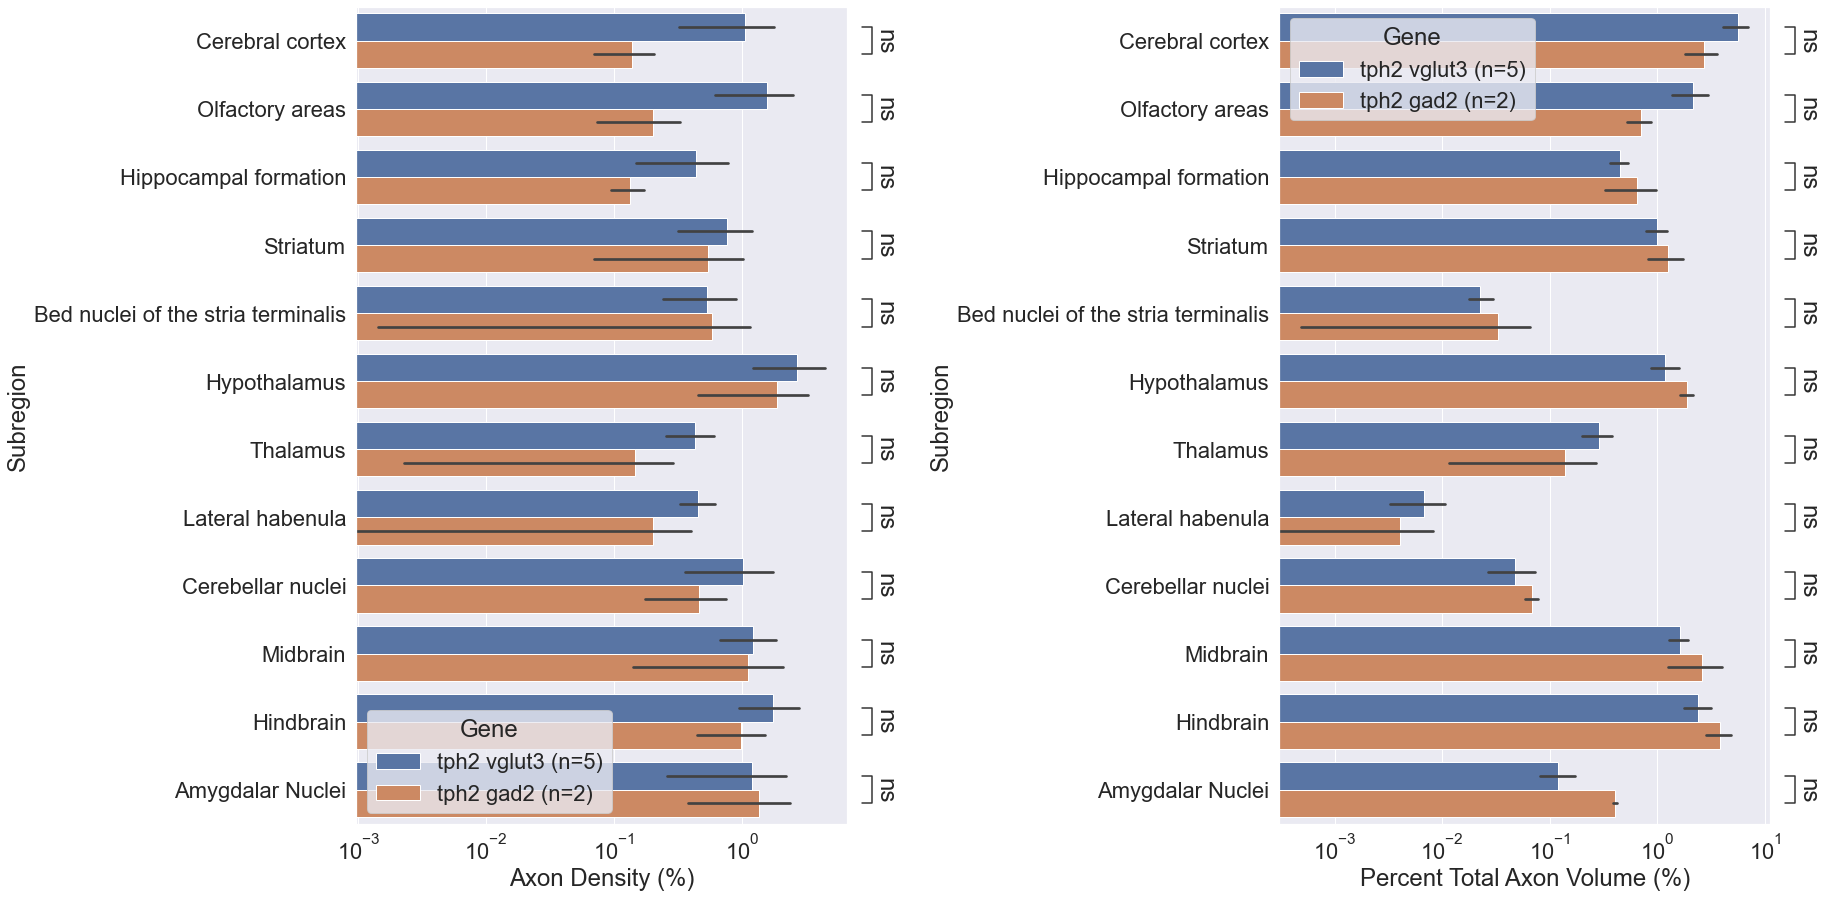

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(26, 13))
sns.set(font_scale=2)

test = "Mann-Whitney"
# test = "t-test_ind"
correction = "fdr_by"

# density
fig_args = {
    "y": "Axon Density (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


genes = df["Gene"].unique()
gene_pairs = [(a, b) for idx, a in enumerate(genes) for b in genes[idx + 1 :]]

for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[0], pairs, **fig_args)
fig_args = {
    "x": "Axon Density (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}


sns.set(font_scale=2)
strpplot = sns.barplot(ax=axes[0], orient="h", **fig_args)
strpplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(strpplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

# percent total
fig_args = {
    "y": "Percent Total Axon Volume (%)",
    "x": "Subregion",
    "hue": "Gene",
    "data": df,
}
pairs = []
unq_subregions = []
for subregion in subregion_name:
    if subregion not in unq_subregions:
        unq_subregions.append(subregion)


for gene_pair in gene_pairs:
    for subregion in unq_subregions:
        pairs.append(
            (
                (subregion, gene_pair[0]),
                (subregion, gene_pair[1]),
            )
        )


annotator = Annotator(axes[1], pairs, **fig_args)
fig_args = {
    "x": "Percent Total Axon Volume (%)",
    "y": "Subregion",
    "hue": "Gene",
    "data": df,
}

strpplot = sns.barplot(ax=axes[1], orient="h", **fig_args)
strpplot.set_xscale("log")

annotator.configure(
    test=test, text_format="star", loc="outside", comparisons_correction=correction
)
annotator.new_plot(strpplot, orient="h", plot="barplot", **fig_args)
annotator.apply_and_annotate()

fig.tight_layout()

## Compare distributions with PCA

In [ ]:
X = []
brain_ids = []
genotypes = []

for i, brain in enumerate(brains):
    print(brain)
    region_order = list(df.loc[df["Brain ID"] == brain]["Region"])

    if i == 0:
        standard_region_order = region_order
    elif standard_region_order != region_order:
        raise ValueError(f"Different region order for brain {brain}")

    distrib = list(df.loc[df["Brain ID"] == brain]["Percent Total Axon Volume (%)"])
    X.append(distrib)

    brain_ids.append(brain)
    genotypes.append(brains[brain])

X = np.array(X)

pca = PCA(n_components=2)
X_2 = pca.fit_transform(X)

df_pca = {
    "PC 1": X_2[:, 0],
    "PC 2": X_2[:, 1],
    "Genotype": genotypes,
    "Brain ID": brain_ids,
}
df_pca = pd.DataFrame(data=df_pca)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="Genotype", ax=ax)


for i in range(df_pca.shape[0]):
    plt.text(
        x=df_pca["PC 1"][i] + 0.03,
        y=df_pca["PC 2"][i] + 0.03,
        s=df_pca["Brain ID"][i],
        fontdict=dict(color="black", size=20),
    )

plt.title(
    f"Projection Distribution PCA with Explained Variance: {pca.explained_variance_ratio_}"
)

# 13. Compare to Allen

## \* Inputs \*

In [ ]:
allen_regions = [
    315,
    698,
    1089,
    703,
    477,
    803,
    549,
    1097,
    313,
    771,
    354,
    512,
]  # allen atlas region IDs to be shown https://connectivity.brain-map.org/projection/experiment/480074702?imageId=480075280&initImage=TWO_PHOTON&x=17028&y=11704&z=3

### Subregion

In [ ]:
axon_denss = []
gene = []
subregion_name = []
region_name = []
subregions_list = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    children = list(G.successors(region))
    for child in children:
        if child not in subregions_list:
            subregions_list.append(child)

        for brain in quantification_dicts.keys():
            if (
                G.nodes[child][brain + " total"] == 0
                and G.nodes[child][brain + " axon"] == 0
            ):
                axon_denss.append(0)
            elif G.nodes[child][brain + " total"] == 0:
                raise ValueError("positive axon volume in zero volume region?")
            else:
                axon_denss.append(
                    G.nodes[child][brain + " axon"] / G.nodes[child][brain + " total"]
                )

            if brain in ["B", "R"]:
                gene.append(brain)
            subregion_name.append(G.nodes[child]["name"])

    region_name.append(G.nodes[region]["name"])

tree = ET.parse(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/sert_exp.xml"
)
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
        if region in subregions_list and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(f"id: {region} hemi: {hemi}, density: {density}, name: {name}")
            subregion_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)


d = {"Axon Density": axon_denss, "Gene": gene, "Subregion": subregion_name}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Detected Output Axons")

sns.barplot(x="Axon Density", y="Subregion", hue="Gene", data=df)
axes.set_title("Density")

fig.tight_layout()

### Region

In [ ]:
axon_denss = []
axon_vols = []
gene = []
region_name = []
for region in allen_regions:
    print(f"Populating: " + G.nodes[region]["name"])
    for brain in quantification_dicts.keys():
        if (
            G.nodes[region][brain + " total"] == 0
            and G.nodes[region][brain + " axon"] == 0
        ):
            axon_denss.append(0)
        elif G.nodes[region][brain + " total"] == 0:
            raise ValueError("positive axon volume in zero volume region?")
        else:
            axon_denss.append(
                G.nodes[region][brain + " axon"] / G.nodes[region][brain + " total"]
            )
            axon_vols.append(
                G.nodes[region][brain + " axon"]
                * np.product([1.82, 1.82, 2])
                * 10 ** (-9)
            )

        if brain in ["B", "R"]:
            gene.append("Sample " + brain)

        region_name.append(G.nodes[region]["name"])

tree = ET.parse(
    "/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/deisseroth/sert_exp.xml"
)
root = tree.getroot()
root.tag
for child in root:
    for i, entry in enumerate(child):
        for item in entry:
            if item.tag == "structure-id":
                region = int(item.text)
            elif item.tag == "hemisphere-id":
                hemi = int(item.text)
            elif item.tag == "is-injection":
                inject = item.text
            elif item.tag == "projection-density":
                density = float(item.text)
            elif item.tag == "projection-volume":
                volume = float(item.text)
        if region in allen_regions and hemi == 3 and inject == "false":
            name = G.nodes[region]["name"]
            print(
                f"id: {region} hemi: {hemi}, density: {density}, volume: {volume}, name: {name}"
            )
            region_name.append(name)
            gene.append("Allen")
            axon_denss.append(density)
            axon_vols.append(volume)


d = {
    "Axon Density": axon_denss,
    "Axon Volume ($mm^3$)": axon_vols,
    "Gene": gene,
    "Region": region_name,
}
df = pd.DataFrame(data=d)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Comparing Axon Volumes to Allen Experiment")

sns.set(font_scale=2)

sns.barplot(
    ax=axes[0],
    x="Axon Density",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[0].set_title("Density")

sns.barplot(
    ax=axes[1],
    x="Axon Volume ($mm^3$)",
    y="Region",
    hue="Gene",
    order=list(
        df[df["Gene"] == "Allen"]
        .sort_values("Axon Density", ascending=False)
        .loc[:, "Region"]
    ),
    data=df,
)
# axes[1].set_title("Axon Volume")

fig.tight_layout()